# L2. EKF Localization 

### Define all the imports

In [29]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# Change to main repo folder for the imports
_, dir = os.path.split(os.getcwd())
if dir == 'notebooks': 
    os.chdir('..')
    sys.path.append(os.getcwd())
pd.set_option('mode.chained_assignment', None)

In [31]:
from src.localization.dead_reckoning import DeadReckoning
from src.localization.EKF import ExtendedKalmanFilter

### Set dataset

In [32]:
# Define dataset to read
dataset = "data/MRCLAM_Dataset2" # Dataset
end_frame = 15000 # Extension of the dataset
robot = 'Robot3' # Robot

### Execute DR estimation

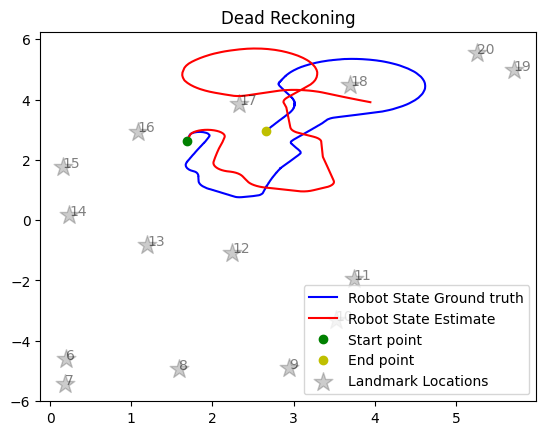

In [33]:
# Build dead reckoning object
dr = DeadReckoning(dataset, robot, end_frame)
dr.run()

### TASK 1. Execute EKF estimation
Complete the extended kalman filter estimation code.

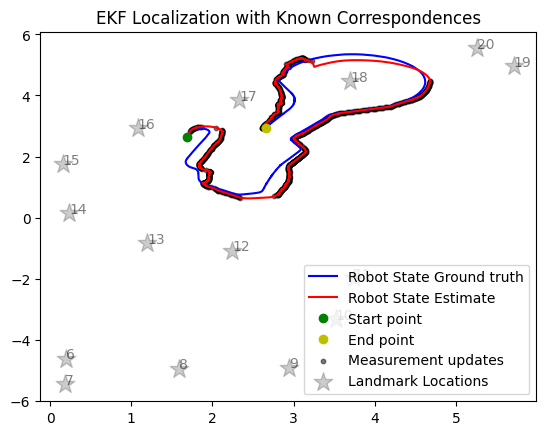

In [34]:
# Build Extended Kalman Filter object
R = np.diagflat(np.array([1.0, 1.0, 1.0]))** 2
Q = np.diagflat(np.array([100, 100, 1e16]))** 2
ekf = ExtendedKalmanFilter(dataset, robot, end_frame, R, Q)

### TASK 2. Compute path error metrics
1. Build a dataframe joining the GT with the dead reckoning and EKF state estimation.

2. Compute the error metrics using the groundtruth states $GT$, the dead reckoning estimated states $S_{DR}$ and the extended Kalman filter estimated states $S_{EKF}$.

The following equations define the normalized accumulated error, the maximum error, and the final position error respectively between a given groundtruth $GT$ and a given state estimation $S$. 

$e_{path} = sum(Error * Delta) / sum(Delta) $

$e_{max} = max(Error) $

$e_{end} = Error[-1]$ 

The vector $Error$ represents the mean squared error (MSE) between the groundtruth and the estimated states.

$Error = mse(GT, S)$

And the $Delta$ represents the vector of displacements.

$Delta = GT[:-1] - GT[1:]$


In [35]:
ekf.build_dataframes()
dr.build_dataframes()

In [41]:
joint_df = dr.gt.join(dr.states, rsuffix = '_dr').dropna()
joint_df = joint_df.join(ekf.states, rsuffix = '_ekf').dropna()

In [42]:
joint_df.head()

,x,y,theta,x_dr,y_dr,theta_dr,x_ekf,y_ekf,theta_ekf
stamp,,,,,,,,,
2009-07-22 15:10:04.920999936,1.683462,2.628265,1.3663,1.683462,2.628265,1.366300,1.683462,2.628265,1.366300
2009-07-22 15:10:08.379000064,1.721801,2.831794,1.2653,1.735027,2.860235,1.180434,1.731907,2.856184,1.186198
2009-07-22 15:10:11.008999936,1.805327,2.920559,0.2314,1.894577,2.992075,0.181852,1.853910,2.978142,0.297302
2009-07-22 15:10:11.172000000,1.813401,2.922999,0.1640,1.908418,2.994280,0.116978,1.867405,2.981926,0.232429
2009-07-22 15:10:16.634000128,1.956318,2.756269,-1.8605,2.142412,2.702252,-1.721803,2.121320,2.743890,-1.564645


### TASK 2. Compute path error metrics
1. Build a dataframe joining the GT with the dead reckoning and EKF state estimation.

2. Compute the error metrics using the groundtruth states $GT$, the dead reckoning estimated states $S_{DR}$ and the extended Kalman filter estimated states $S_{EKF}$.

The following equations define the normalized accumulated error, the maximum error, and the final position error respectively between a given groundtruth $GT$ and a given state estimation $S$. 

$e_{path} = sum(Error * Delta) / sum(Delta) $

$e_{max} = max(Error) $

$e_{end} = Error[-1]$ 

The vector $Error$ represents the mean squared error (MSE) between the groundtruth and the estimated states.

$Error = mse(GT, S)$

And the $Delta$ represents the vector of displacements.

$Delta = GT[:-1] - GT[1:]$


In [102]:
def normalized_path_error(position, technique):
    d_gt_dis = []
    x_gt = position["x"].tolist()
    y_gt = position["y"].tolist()
    for i in range(len(x_gt) - 1):
        path_error = np.sqrt(np.power(x_gt[i] - x_gt[i+1], 2) + np.power(y_gt[i] - y_gt[i+1], 2))
        d_gt_dis.append(path_error)
    x_state = []
    y_state = []
    if technique == 'dr':
        x_state = position["x_dr"].tolist()
        y_state = position["y_dr"].tolist()
    elif technique == 'ekf':
        x_state = position["x_ekf"].tolist()
        y_state = position["y_ekf"].tolist()
        
    err_list = []
    weighted_err_list = []
    for i in range(1, len(x_gt)):
        path_error = np.sqrt(np.power(x_gt[i] - x_state[i], 2) + np.power(y_gt[i] - y_state[i], 2))
        err_list.append(path_error)
        weighted_err_list.append(path_error * d_gt_dis[i-1])
    e_path = np.sum(weighted_err_list) / np.sum(d_gt_dis)
    e_max = np.max(err_list)
    e_end = err_list[-1]
    return e_path, e_max, e_end

In [107]:
def normalized_path_error_group(position):
    d_gt_dis = []
    x_gt = position["x_gt"].tolist()
    y_gt = position["y_gt"].tolist()
    for i in range(len(x_gt) - 1):
        path_error = np.sqrt(np.power(x_gt[i] - x_gt[i+1], 2) + np.power(y_gt[i] - y_gt[i+1], 2))
        d_gt_dis.append(path_error)

    x_state = position["x"].tolist()
    y_state = position["y"].tolist()
        
    err_list = []
    weighted_err_list = []
    for i in range(1, len(x_gt)):
        path_error = np.sqrt(np.power(x_gt[i] - x_state[i], 2) + np.power(y_gt[i] - y_state[i], 2))
        err_list.append(path_error)
        weighted_err_list.append(path_error * d_gt_dis[i-1])
    e_path = np.sum(weighted_err_list) / np.sum(d_gt_dis)
    e_max = np.max(err_list)
    e_end = err_list[-1]
    return e_path, e_max, e_end

In [103]:
e_path, e_max, e_end = normalized_path_error(joint_df, 'dr')

In [104]:
e_path, e_max, e_end

(0.9911850836688794, 2.231237411956989, 1.6112793755521377)

In [105]:
e_path, e_max, e_end = normalized_path_error(joint_df, 'ekf')

In [106]:
e_path, e_max, e_end

(0.12484973158384712, 0.3513974641487107, 0.04401305380086609)

### TASK 3. Iterate over diferent datasets
Here we are interested on executing multiple experiments using different robots and datasets and get the three error metrics from previous blocks for all the experiments and enable further analisis of this errors.

The iterative execution of different experiments will enable as to compare different localization algorithms on further lab sessions.

#### Generate metrics

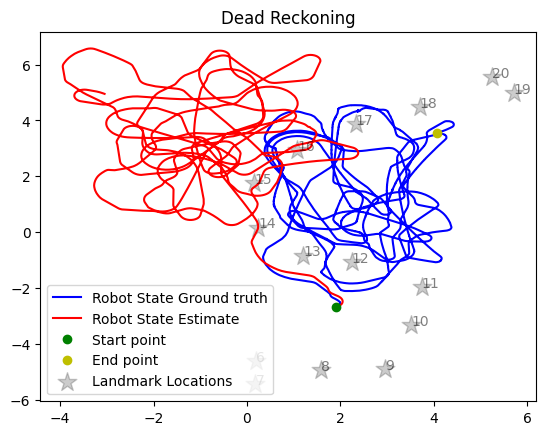

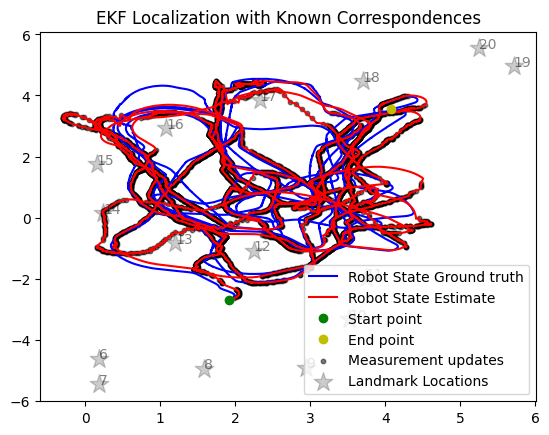

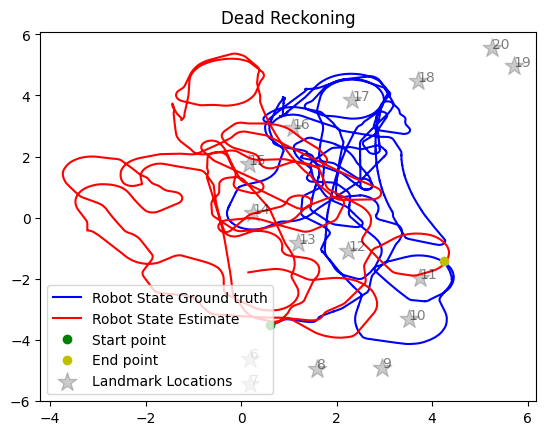

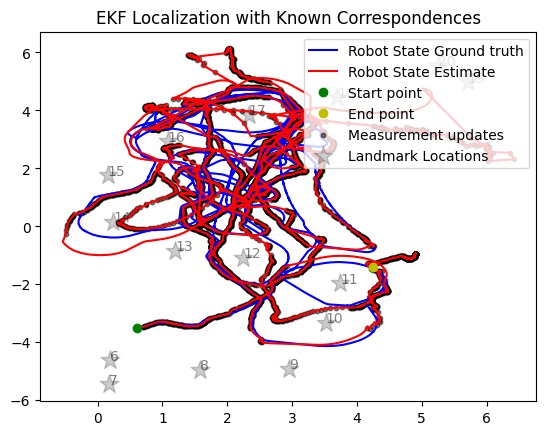

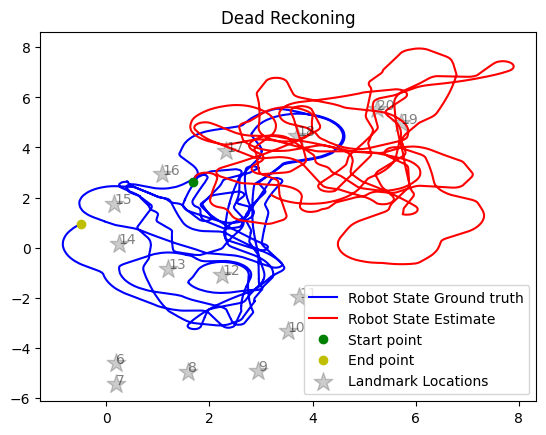

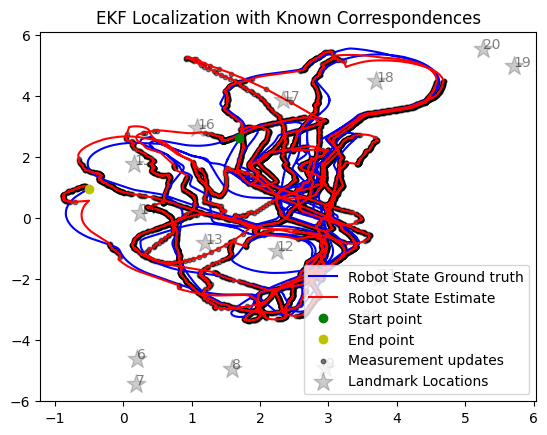

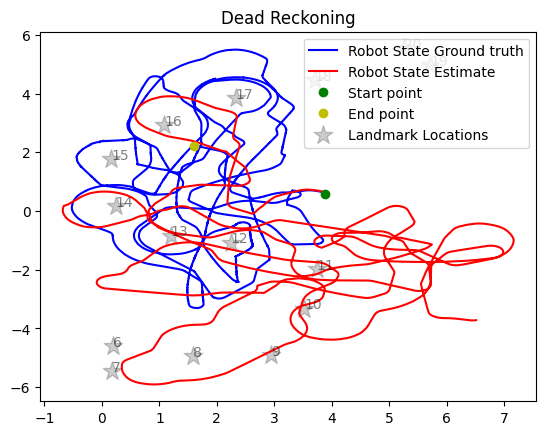

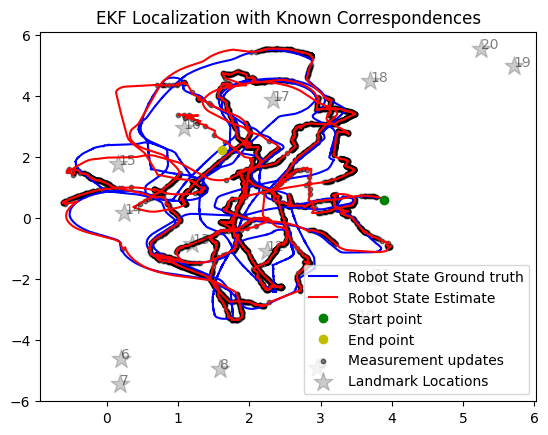

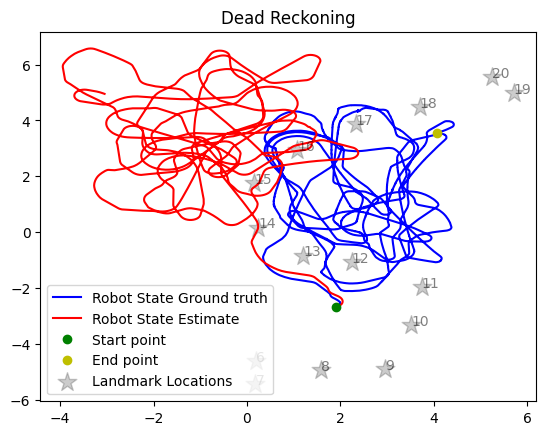

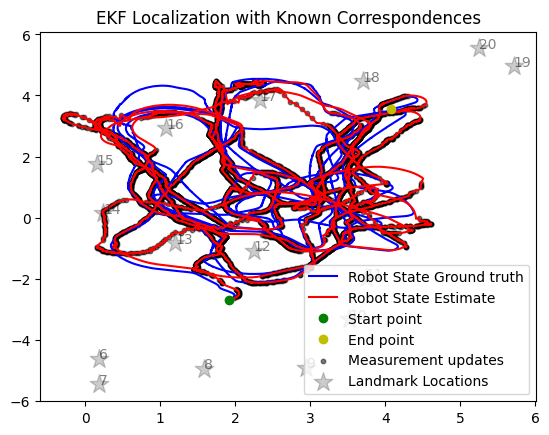

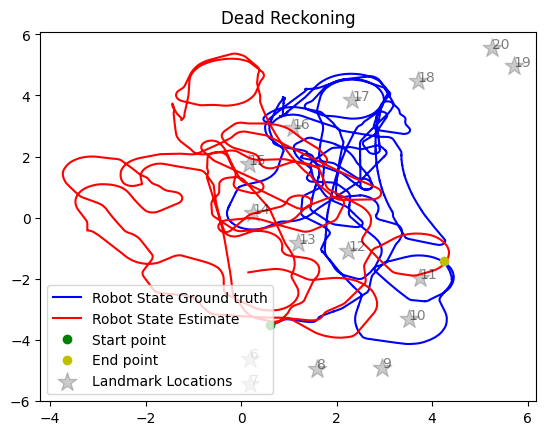

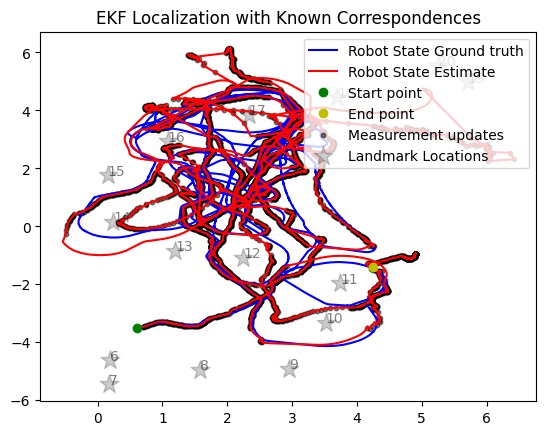

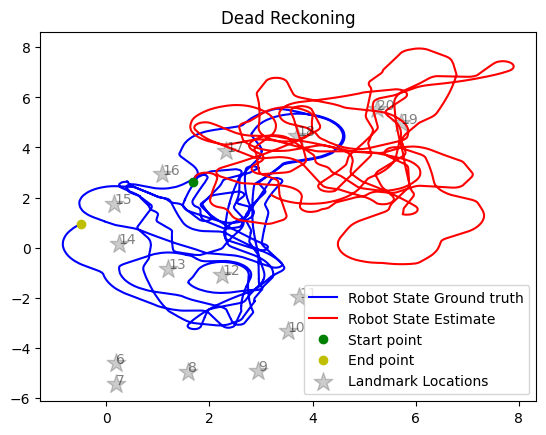

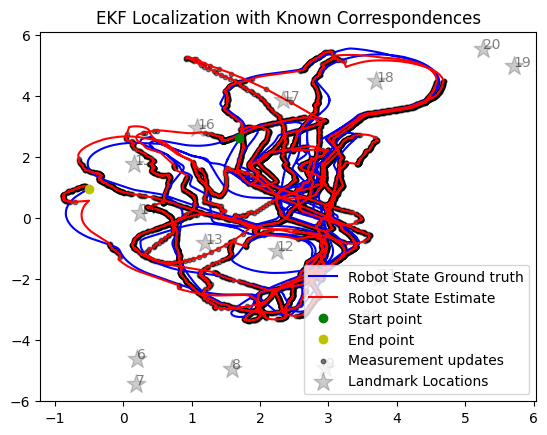

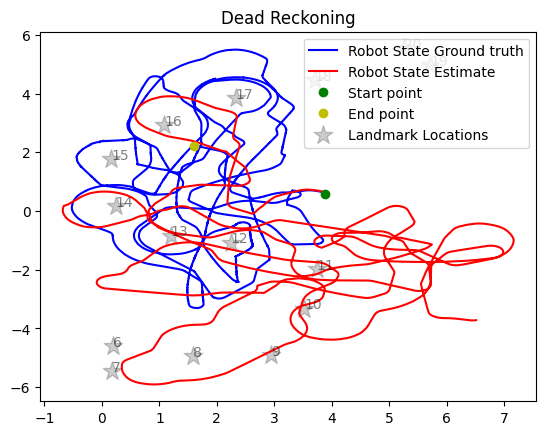

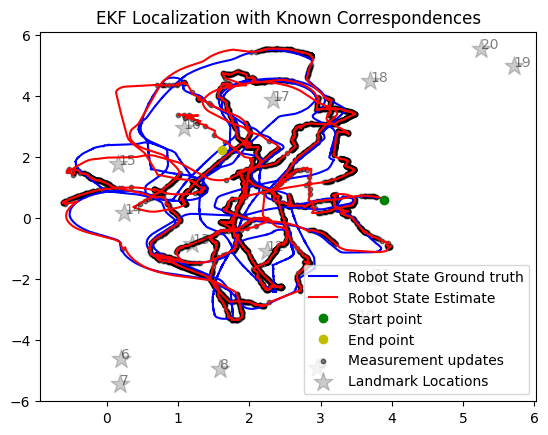

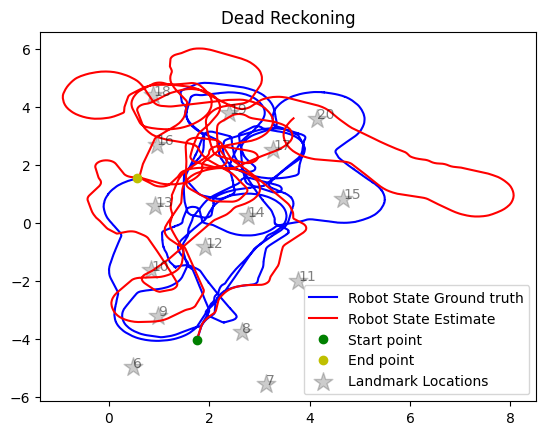

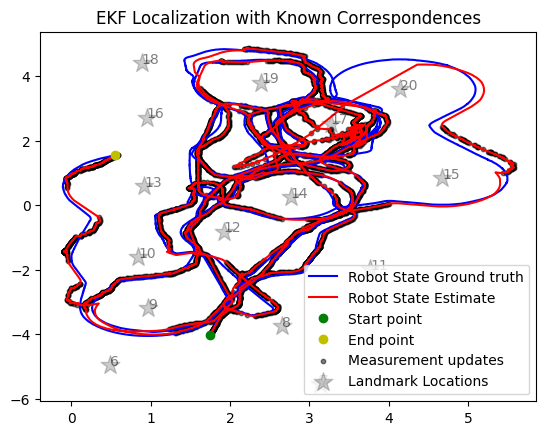

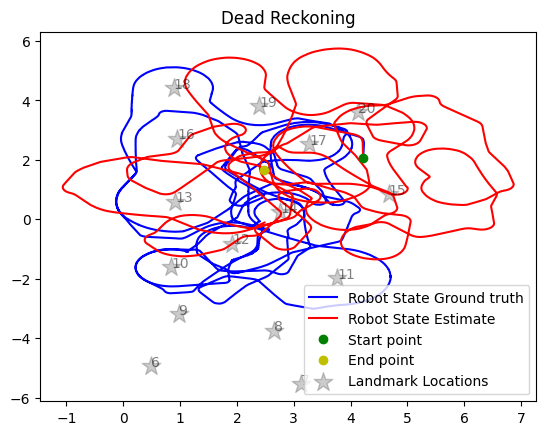

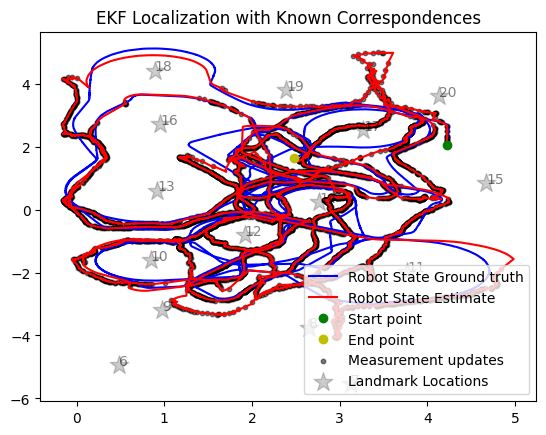

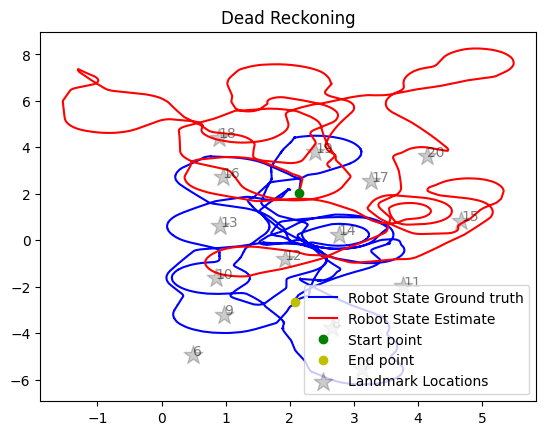

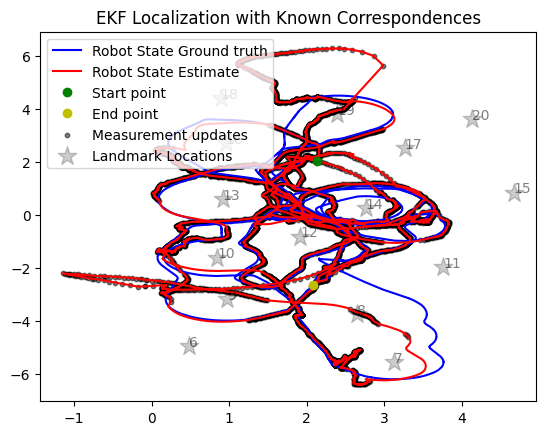

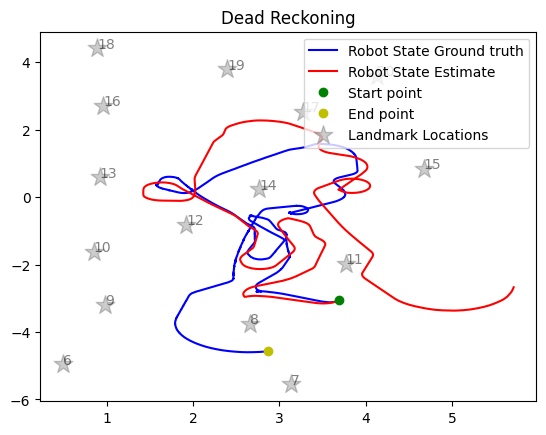

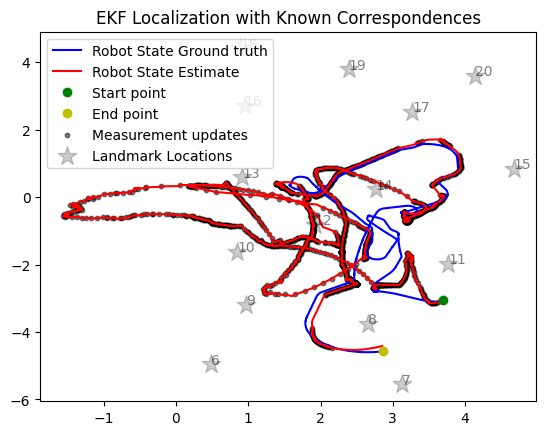

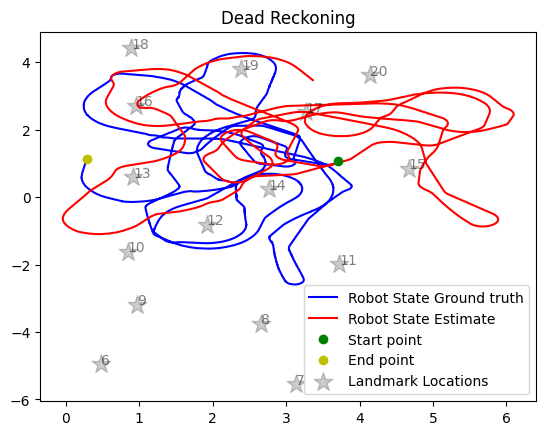

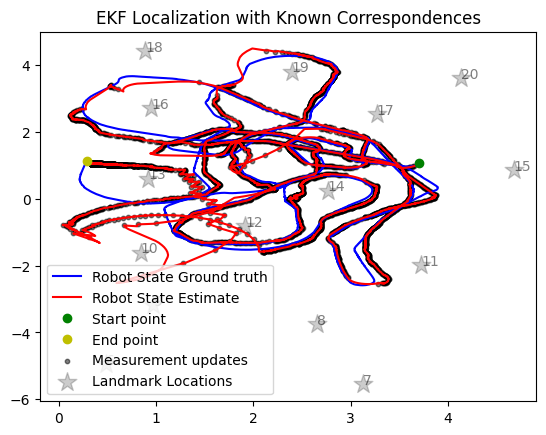

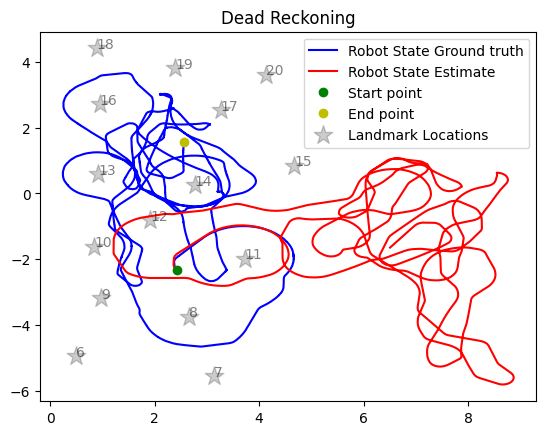

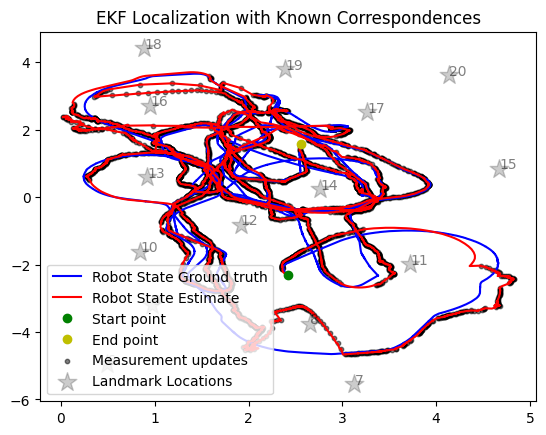

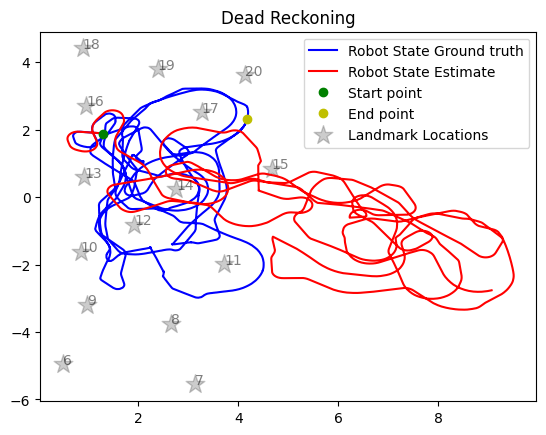

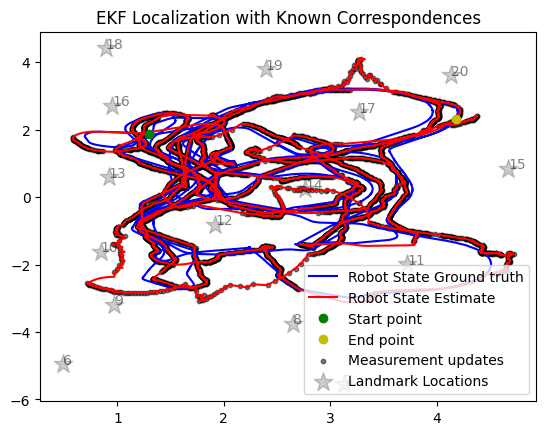

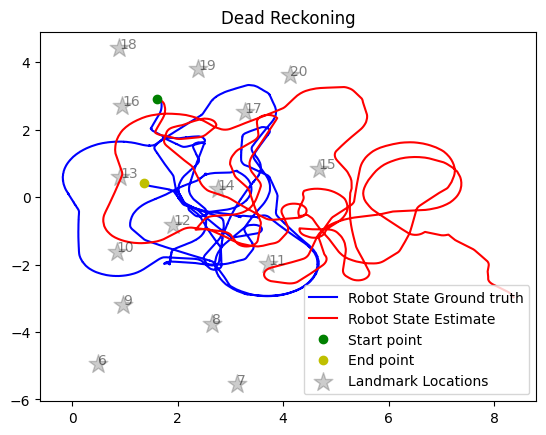

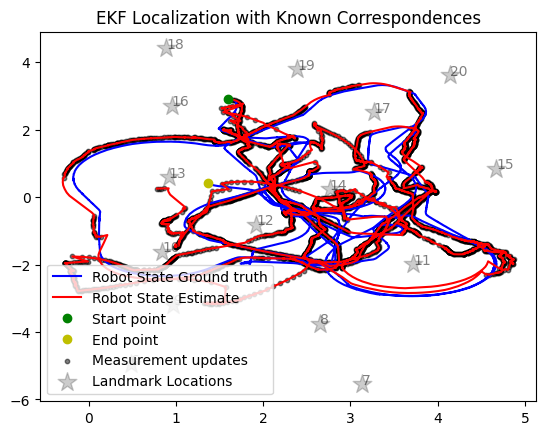

In [127]:
datasets = ["data/MRCLAM_Dataset2",
            "data/MRCLAM_Dataset2",
            "data/MRCLAM_Dataset3",
            "data/MRCLAM_Dataset4"]
robots = ['Robot1',
          'Robot2',
          'Robot3',
          'Robot4']

errors = pd.DataFrame(columns=['dataset','robot','technique','path_error','max_error','final_error'])
techniques = ['dr', 'ekf']

for ds in datasets:
   for rob in robots:
    for t in techniques:
        st = None
        if t == 'dr':
            st = DeadReckoning(ds, rob, -1)
            st.run()
        elif t == 'ekf':
            R = np.diagflat(np.array([1.0, 1.0, 1.0]))** 2
            Q = np.diagflat(np.array([100, 100, 1e16]))** 2
            st = ExtendedKalmanFilter(ds, rob, -1, R, Q)
        st.build_dataframes()
        joint_df = st.states.join(st.gt, rsuffix = '_gt').dropna()
        e_path, e_max, e_end = normalized_path_error_group(joint_df)
        errors.loc[-1] = [ds, rob, t, e_path, e_max, e_end]
        errors.index = errors.index + 1  # shifting index
        errors = errors.sort_index()

#### Represent metrics
For instance you could use the catplot of the seaborn library. Feel free to use another informative plot.

In [131]:
# Represent metrics for all experiments
errors.head(33)

,dataset,robot,technique,path_error,max_error,final_error
0,data/MRCLAM_Dataset4,Robot4,ekf,0.266016,2.291587,0.472074
1,data/MRCLAM_Dataset4,Robot4,dr,2.244101,7.777305,7.777305
2,data/MRCLAM_Dataset4,Robot3,ekf,0.144297,1.689828,0.216515
3,data/MRCLAM_Dataset4,Robot3,dr,4.198145,8.558956,7.054514
4,data/MRCLAM_Dataset4,Robot2,ekf,0.171645,2.361573,0.064737
5,data/MRCLAM_Dataset4,Robot2,dr,4.903705,7.736520,5.026426
6,data/MRCLAM_Dataset4,Robot1,ekf,0.215260,3.021726,0.158442
7,data/MRCLAM_Dataset4,Robot1,dr,2.374671,6.065254,3.866634
8,data/MRCLAM_Dataset3,Robot4,ekf,0.632656,4.811951,0.156111
9,data/MRCLAM_Dataset3,Robot4,dr,0.973076,3.476975,3.417866


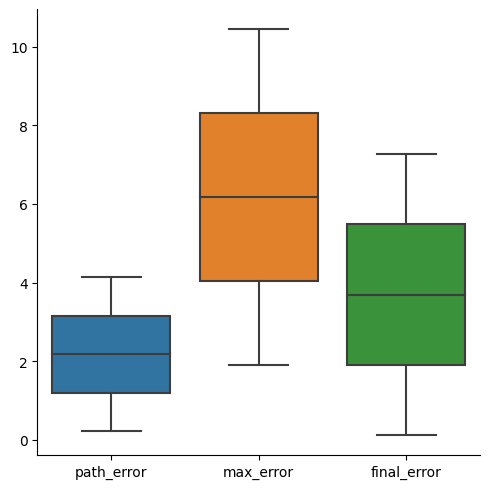

In [125]:
sns.catplot(data=errors, kind='box')

#### Analize metrics

In [9]:
# Analize the results and provide the mean error metrics across the experiments performed.